In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
processed_path = r"C:\Users\ruham\Downloads\financial inclusion forecasting system\Financial-inclusion-forecasting-system-week10\data\processed"
reports_path = r"C:\Users\ruham\Downloads\ethiopia-fi-forecast\reports\figures"


In [6]:
# List all forecast Excel files
forecast_files = [f for f in os.listdir(processed_path) if f.endswith('_forecast.xlsx')]

# Load all forecasts into a single DataFrame
all_forecasts = pd.DataFrame()

for f in forecast_files:
    df = pd.read_excel(os.path.join(processed_path, f))
    df['indicator_code'] = f.replace('_forecast.xlsx', '')  # add indicator column
    all_forecasts = pd.concat([all_forecasts, df], ignore_index=True)

# Quick check
print("All forecasts shape:", all_forecasts.shape)
all_forecasts.head()


All forecasts shape: (2, 4)


,observation_date,actual,forecast,indicator_code
0,2024-11-29,49,32.451317,ACC_OWNERSHIP
1,2025-12-31,70,32.575249,ACC_OWNERSHIP


In [7]:
# Ensure observation_date is datetime
all_forecasts['observation_date'] = pd.to_datetime(all_forecasts['observation_date'], errors='coerce')

# Aggregate by month per indicator
all_forecasts['month'] = all_forecasts['observation_date'].dt.to_period('M')

agg_forecasts = all_forecasts.groupby(['indicator_code', 'month']).agg(
    actual_mean=('actual', 'mean'),
    forecast_mean=('forecast', 'mean'),
    actual_sum=('actual', 'sum'),
    forecast_sum=('forecast', 'sum')
).reset_index()

agg_forecasts['month'] = agg_forecasts['month'].dt.to_timestamp()

print("Aggregated forecasts:")
agg_forecasts.head()


Aggregated forecasts:


,indicator_code,month,actual_mean,forecast_mean,actual_sum,forecast_sum
0,ACC_OWNERSHIP,2024-11-01,49.0,32.451317,49,32.451317
1,ACC_OWNERSHIP,2025-12-01,70.0,32.575249,70,32.575249


In [8]:
# Calculate error
agg_forecasts['error'] = agg_forecasts['forecast_mean'] - agg_forecasts['actual_mean']
agg_forecasts['abs_error'] = agg_forecasts['error'].abs()

# Summary stats
print(agg_forecasts.describe())

# Indicators with largest errors
top_errors = agg_forecasts.sort_values('abs_error', ascending=False).head(10)
print(top_errors)


                     month  actual_mean  forecast_mean  actual_sum  \
count                    2     2.000000       2.000000    2.000000   
mean   2025-05-17 12:00:00    59.500000      32.513283   59.500000   
min    2024-11-01 00:00:00    49.000000      32.451317   49.000000   
25%    2025-02-07 18:00:00    54.250000      32.482300   54.250000   
50%    2025-05-17 12:00:00    59.500000      32.513283   59.500000   
75%    2025-08-24 06:00:00    64.750000      32.544266   64.750000   
max    2025-12-01 00:00:00    70.000000      32.575249   70.000000   
std                    NaN    14.849242       0.087633   14.849242   

       forecast_sum      error  abs_error  
count      2.000000   2.000000   2.000000  
mean      32.513283 -26.986717  26.986717  
min       32.451317 -37.424751  16.548683  
25%       32.482300 -32.205734  21.767700  
50%       32.513283 -26.986717  26.986717  
75%       32.544266 -21.767700  32.205734  
max       32.575249 -16.548683  37.424751  
std        0.0876

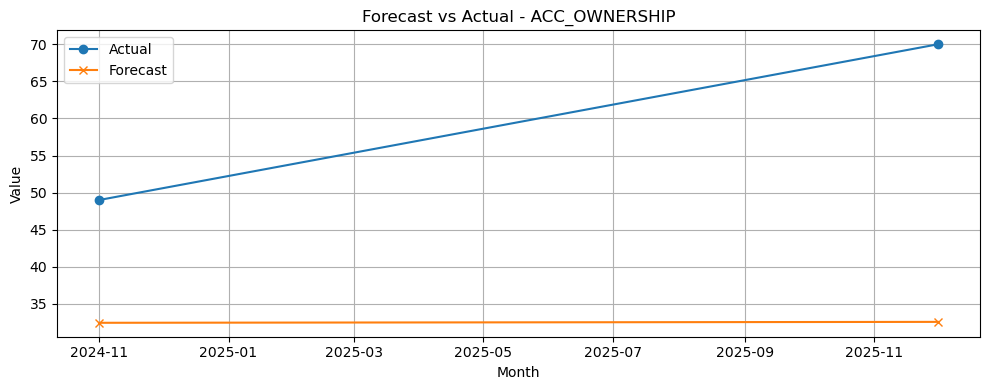

All plots saved successfully!


In [10]:
# Ensure the folder exists
os.makedirs(reports_path, exist_ok=True)

# Plot forecasts for top indicators
top_indicators = agg_forecasts.groupby('indicator_code')['abs_error'].mean().sort_values(ascending=False).head(3).index

for indicator in top_indicators:
    df_plot = agg_forecasts[agg_forecasts['indicator_code'] == indicator]
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['month'], df_plot['actual_mean'], label='Actual', marker='o')
    plt.plot(df_plot['month'], df_plot['forecast_mean'], label='Forecast', marker='x')
    plt.title(f'Forecast vs Actual - {indicator}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    file_path = os.path.join(reports_path, f'{indicator}_forecast_plot.png')
    plt.savefig(file_path)
    plt.show()

print("All plots saved successfully!")


In [11]:
agg_forecasts.to_excel(os.path.join(processed_path, 'all_aggregated_forecasts.xlsx'), index=False)
print("Aggregated forecasts saved successfully!")


Aggregated forecasts saved successfully!
